<div style="width:1000 px">

<div style="float:right; width:98 px; height:98px;"><img src="https://pbs.twimg.com/profile_images/1187259618/unidata_logo_rgb_sm_400x400.png" alt="Unidata Logo" style="height: 98px;"></div>

<h1>Making an Interactive RGB Composite</h1>
<h3>Unidata Python Workshop</h3>

<div style="clear:both"></div>
</div>

<hr style="height:2px;">

In [7]:
from datetime import datetime

import cartopy.crs as ccrs
import cartopy.feature as cfeat
from IPython.display import display
from ipywidgets import Dropdown, interact, fixed, Select
from matplotlib import patheffects
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import numpy as np
from scipy import interpolate
from siphon.catalog import TDSCatalog

In [8]:
def open_dataset(date, channel, idx, region):
    """
    Open and return a netCDF Dataset object for a given date, channel, and image index
    of GOES-16 data from THREDDS test server.
    """
    cat = TDSCatalog('http://thredds-test.unidata.ucar.edu/thredds/catalog/satellite/goes16/GOES16/'
                 '{}/Channel{:02d}/{:%Y%m%d}/catalog.xml'.format(region, channel, date))
    ds = cat.datasets[idx].remote_access(service='OPENDAP')                     
    return ds

In [9]:
def plot_GOES16_channel(date, idx, channel, region):
    """
    Get and plot a GOES 16 data band from the ABI.
    """
    ds = open_dataset(date, channel, idx, region)
    x = ds.variables['x'][:]
    y = ds.variables['y'][:]
    z = ds.variables['Sectorized_CMI'][:]
    proj_var = ds.variables[ds.variables['Sectorized_CMI'].grid_mapping]

    # Create a Globe specifying a spherical earth with the correct radius
    globe = ccrs.Globe(ellipse='sphere', semimajor_axis=proj_var.semi_major,
                       semiminor_axis=proj_var.semi_minor)

    proj = ccrs.LambertConformal(central_longitude=proj_var.longitude_of_central_meridian,
                                 central_latitude=proj_var.latitude_of_projection_origin,
                                 standard_parallels=[proj_var.standard_parallel],
                                 globe=globe)


    # Set up a feature for the state/province lines. Tell cartopy not to fill in the polygons
    state_boundaries = cfeat.NaturalEarthFeature(category='cultural',
                                                 name='admin_1_states_provinces_lakes',
                                                 scale='50m', facecolor='none')

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1, projection=proj)
    ax.coastlines(resolution='50m', color='black')
    ax.add_feature(state_boundaries, linestyle=':', edgecolor='black')
    ax.add_feature(cfeat.BORDERS, linewidth='2', edgecolor='black')

    for im in ax.images:
        im.remove()
    im = ax.imshow(z, extent=(x.min(), x.max(), y.min(), y.max()), origin='upper')
    timestamp = datetime.strptime(ds.start_date_time, '%Y%j%H%M%S')
    # Add text (aligned to the right); save the returned object so we can manipulate it.
    text_time = ax.text(0.99, 0.01, timestamp.strftime('%d %B %Y %H%MZ'),
                   horizontalalignment='right', transform=ax.transAxes,
                   color='white', fontsize='x-large', weight='bold')

    text_channel = ax.text(0.5, 0.94, 'Channel {}'.format(channel),
                   horizontalalignment='center', transform=ax.transAxes,
                   color='white', fontsize='large', weight='bold')
    
    text_experimental = ax.text(0.5, 0.97, 'Experimental GOES-16 Data',
               horizontalalignment='center', transform=ax.transAxes,
               color='white', fontsize='large', weight='bold')

    # Make the text stand out even better using matplotlib's path effects
    # Make the text stand out even better using matplotlib's path effects
    outline_effect = [patheffects.withStroke(linewidth=2, foreground='black')]
    text_time.set_path_effects(outline_effect)
    text_channel.set_path_effects(outline_effect)
    text_experimental.set_path_effects(outline_effect)
    display(fig)
    plt.close()

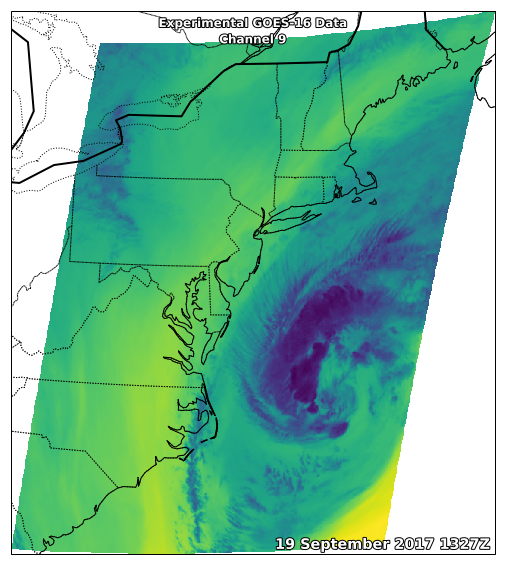

<function __main__.plot_GOES16_channel>

In [12]:
channel_list = {u'1 - Blue Band 0.47 \u03BCm': 1,
                u'2 - Red Band 0.64 \u03BCm': 2,
                u'3 - Veggie Band 0.86 \u03BCm': 3,
                u'4 - Cirrus Band 1.37 \u03BCm': 4,
                u'5 - Snow/Ice Band 1.6 \u03BCm': 5,
                u'6 - Cloud Particle Size Band 2.2 \u03BCm': 6,
                u'7 - Shortwave Window Band 3.9 \u03BCm': 7,
                u'8 - Upper-Level Tropo. WV Band 6.2 \u03BCm': 8,
                u'9 - Mid-Level Tropo. WV Band 6.9 \u03BCm': 9,
                u'10 - Low-Level WV Band 7.3 \u03BCm': 10,
                u'11 - Cloud-Top Phase Band 8.4 \u03BCm': 11,
                u'12 - Ozone Band 9.6 \u03BCm': 12,
                u'13 - Clean IR Longwave Band 10.3 \u03BCm': 13,
                u'14 - IR Longwave Band 11.2 \u03BCm': 14,
                u'15 - Dirty Longwave Band 12.3 \u03BCm': 15,
                u'16 - CO2 Longwave IR 13.3 \u03BCm': 16}

region = Select(
    options=['Mesoscale-1', 'Mesoscale-2', 'CONUS'],
    description='Region:',
)

channel = Dropdown(
    options=channel_list,
    value=9,
    description='Channel:',
)

date = datetime.utcnow()
interact(plot_GOES16_channel, date=fixed(date), idx=fixed(-2), 
         channel=channel, region=region)